### Vitを用いた医療画像２クラス分類


In [6]:
from __future__ import print_function

import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

import copy
from tqdm import tqdm

In [7]:
config={
    'BatchSize':128,
    'seed':42,
    'n_epochs' : 50,
    'lr' : 0.001,
    'gamma':0.7
}

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config['seed'])

In [9]:
device = 'cuda'
train_dataset_dir = Path('data/Gender01/train')
val_dataset_dir = Path('data/Gender01/validation')
test_dataset_dir = Path('data//Gender01/test')

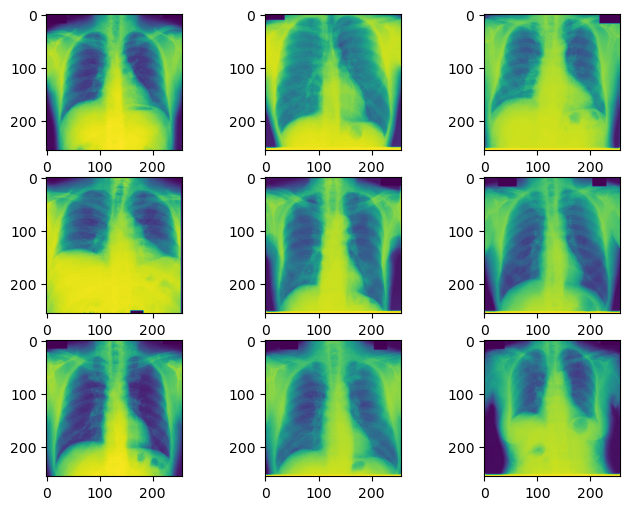

In [10]:
files = glob.glob('data/Gender01/*/*/*.png')
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img)

In [11]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [12]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)
test_data = datasets.ImageFolder(test_dataset_dir, test_transforms)

In [13]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=False)

### timmを使ってViTのモデルをダウンロードして、さらに転移学習を実行
- コードを実行すると、ロードできるモデルの一覧が表示される

In [14]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

- pretrain=Trueにすることで重みの学習が行われる。
- num_classは分類するクラス数を示している。今回は2クラスを指定

In [15]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
model = model.to(device)

/home/bdr/anaconda3/envs/deep/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


In [16]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=config['lr'])
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=config['gamma'])

In [17]:
best_loss = None

# Accuracy計算用の関数
def calculate_accuracy(output, target):
    output = (torch.sigmoid(output) >= 0.5)
    target = (target == 1.0)
    accuracy = torch.true_divide((target == output).sum(dim=0), output.size(0)).item()
    return accuracy

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(config['n_epochs']):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

    if (best_loss is None) or (best_loss > val_loss):
        best_loss = val_loss
        model_path = '../model/bestViTmodel.pth'
        torch.save(model.state_dict(), model_path)
        
    print()


100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Epoch : 1 - loss : 4.1105 - acc: 0.5437 - val_loss : 0.6728 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Epoch : 2 - loss : 0.7714 - acc: 0.4263 - val_loss : 0.9824 - val_acc: 0.4375




100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Epoch : 3 - loss : 0.7970 - acc: 0.5562 - val_loss : 0.8682 - val_acc: 0.4375




100%|██████████| 10/10 [00:01<00:00,  5.29it/s]


Epoch : 4 - loss : 0.9222 - acc: 0.4525 - val_loss : 0.8109 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch : 5 - loss : 0.8211 - acc: 0.5062 - val_loss : 0.6679 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Epoch : 6 - loss : 0.8030 - acc: 0.5438 - val_loss : 0.6716 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Epoch : 7 - loss : 0.8267 - acc: 0.5437 - val_loss : 0.6949 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch : 8 - loss : 1.0051 - acc: 0.5388 - val_loss : 0.8606 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch : 9 - loss : 0.8074 - acc: 0.5525 - val_loss : 0.7051 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


Epoch : 10 - loss : 0.8081 - acc: 0.5100 - val_loss : 0.6766 - val_acc: 0.5625




100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Epoch : 11 - loss : 0.7972 - acc: 0.4863 - val_loss : 0.7555 - val_acc: 0.4375




100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Epoch : 12 - loss : 0.7652 - acc: 0.5000 - val_loss : 0.8221 - val_acc: 0.4375




100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Epoch : 13 - loss : 0.7215 - acc: 0.5475 - val_loss : 0.7314 - val_acc: 0.4375




100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Epoch : 14 - loss : 0.7281 - acc: 0.5288 - val_loss : 0.9916 - val_acc: 0.4375




100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Epoch : 15 - loss : 0.7502 - acc: 0.5300 - val_loss : 0.6403 - val_acc: 0.6399




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch : 16 - loss : 0.8378 - acc: 0.5288 - val_loss : 0.6615 - val_acc: 0.5625




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 17 - loss : 0.6936 - acc: 0.4975 - val_loss : 0.6554 - val_acc: 0.5625




100%|██████████| 10/10 [00:02<00:00,  4.73it/s]


Epoch : 18 - loss : 0.7610 - acc: 0.4588 - val_loss : 0.6385 - val_acc: 0.5833




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch : 19 - loss : 0.6835 - acc: 0.5913 - val_loss : 0.6965 - val_acc: 0.4881




100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Epoch : 20 - loss : 0.5748 - acc: 0.7400 - val_loss : 1.1087 - val_acc: 0.5089




100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch : 21 - loss : 0.6774 - acc: 0.5888 - val_loss : 0.8183 - val_acc: 0.4613




100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


Epoch : 22 - loss : 0.5872 - acc: 0.6700 - val_loss : 0.6421 - val_acc: 0.6042




100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Epoch : 23 - loss : 0.6106 - acc: 0.6975 - val_loss : 0.7302 - val_acc: 0.5119




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch : 24 - loss : 0.6650 - acc: 0.5987 - val_loss : 0.6750 - val_acc: 0.6012




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch : 25 - loss : 0.6039 - acc: 0.7050 - val_loss : 1.0633 - val_acc: 0.5089




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 26 - loss : 0.6700 - acc: 0.6625 - val_loss : 0.7884 - val_acc: 0.4375




100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch : 27 - loss : 0.5497 - acc: 0.7400 - val_loss : 0.7234 - val_acc: 0.6607




100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Epoch : 28 - loss : 0.5178 - acc: 0.7563 - val_loss : 0.6258 - val_acc: 0.6190




100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch : 29 - loss : 0.5629 - acc: 0.7450 - val_loss : 0.7126 - val_acc: 0.6667




100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch : 30 - loss : 0.4446 - acc: 0.7900 - val_loss : 0.6390 - val_acc: 0.7202




100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch : 31 - loss : 0.4847 - acc: 0.8088 - val_loss : 0.6289 - val_acc: 0.7173




100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Epoch : 32 - loss : 0.3846 - acc: 0.8613 - val_loss : 0.6887 - val_acc: 0.7143




100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch : 33 - loss : 0.6186 - acc: 0.7600 - val_loss : 0.6734 - val_acc: 0.6667




100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Epoch : 34 - loss : 0.6095 - acc: 0.6737 - val_loss : 0.5603 - val_acc: 0.6667




100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch : 35 - loss : 0.5148 - acc: 0.7525 - val_loss : 0.5467 - val_acc: 0.7173




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 36 - loss : 0.4177 - acc: 0.8188 - val_loss : 0.5976 - val_acc: 0.7232




100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch : 37 - loss : 0.4342 - acc: 0.8125 - val_loss : 0.5891 - val_acc: 0.7351




100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch : 38 - loss : 0.3609 - acc: 0.8712 - val_loss : 0.6197 - val_acc: 0.7202




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 39 - loss : 0.3637 - acc: 0.8350 - val_loss : 0.7101 - val_acc: 0.7202




100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Epoch : 40 - loss : 0.4221 - acc: 0.8050 - val_loss : 0.6277 - val_acc: 0.7470




100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch : 41 - loss : 0.4795 - acc: 0.7837 - val_loss : 0.8290 - val_acc: 0.6488




100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch : 42 - loss : 0.3758 - acc: 0.8275 - val_loss : 0.6293 - val_acc: 0.7381




100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Epoch : 43 - loss : 0.2716 - acc: 0.9150 - val_loss : 0.6069 - val_acc: 0.6994




100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch : 44 - loss : 0.4063 - acc: 0.8400 - val_loss : 0.6170 - val_acc: 0.6875




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 45 - loss : 0.3250 - acc: 0.8837 - val_loss : 0.7483 - val_acc: 0.6815




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 46 - loss : 0.2863 - acc: 0.8875 - val_loss : 0.7175 - val_acc: 0.6786




100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch : 47 - loss : 0.3393 - acc: 0.8625 - val_loss : 0.7318 - val_acc: 0.7143




100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch : 48 - loss : 0.3984 - acc: 0.8487 - val_loss : 0.7004 - val_acc: 0.6905




100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch : 49 - loss : 0.3544 - acc: 0.8300 - val_loss : 0.6219 - val_acc: 0.6964




100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch : 50 - loss : 0.4392 - acc: 0.7713 - val_loss : 0.7782 - val_acc: 0.6042




/tmp/ipykernel_66200/3202875075.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


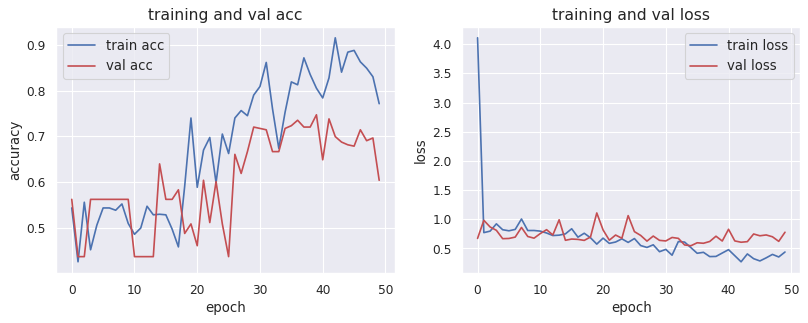

In [18]:
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(config['n_epochs']):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = config['n_epochs']

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [20]:
model.eval()  # モデルを評価モードにする

loss_sum = 0
correct = 0

with torch.no_grad():
    for data, labels in test_loader:

        # GPUが使えるならGPUにデータを送る
        data = data.to(device)
        labels = labels.to(device)

        # ニューラルネットワークの処理を実施
        outputs = model(data)

        # 損失(出力とラベルとの誤差)の計算
        loss_sum += criterion(outputs, labels)

        # 正解の値を取得
        pred = outputs.argmax(1)
        # 正解数をカウント
        correct += pred.eq(labels.view_as(pred)).sum().item()

print(f"Loss: {loss_sum.item() / len(test_loader)}, Accuracy: {100*correct/len(test_data)}% ({correct}/{len(test_data)})")


Loss: 0.667330265045166, Accuracy: 61.702127659574465% (29/47)
